In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import json

from modules.interfaces import User, DataBase
from modules.managers import PretradeDataManager, OrderManager, PortfolioManager
from modules.portfolio import *
from modules.tools import *

from modules.trading_models.indicators import TechnicalIndicator
from modules.trading_models.rule_based_models import FilteredBollingerBand,BollingerBand

In [3]:
ac_info = read_json("config/mt5_account.json")["ftmo-demo"]
pre_db_info = read_json("config/postgres_info.json")["pre-trade"]
post_db_info = read_json("config/postgres_info.json")["post-trade"]
params = read_json("config/parameters.json")
asset_allocation = read_json("config/asset_allocation.json")

In [4]:
user = User().login_by_dict(ac_info)
pre_db = DataBase().connect_by_dict(pre_db_info)
post_db = DataBase().connect_by_dict(post_db_info)

Logged in as 1520198341 (FTMO-Demo2)
Connected to pre-trade (localhost:5432)
Connected to post-trade (localhost:5432)


In [5]:
pdm = PretradeDataManager(user, pre_db)
om = OrderManager(user, post_db)
pm = PortfolioManager(om, pdm, asset_allocation, params)

In [7]:
uni = pdm.get_universe()

In [11]:
uni.loc[uni.asset_class=='metal']

,id,symbol,asset_class,currency_base,currency_margin,currency_profit,description,digits,point,spread,trade_contract_size,trade_tick_size,trade_tick_value
52,3001,XAGAUD,metal,USD,AUD,AUD,Silver Spot Australian Dollar,3,0.001,10,5000,0.001,3.31865
53,3002,XAGEUR,metal,USD,EUR,EUR,Silver Spot Euro,3,0.001,8,5000,0.001,5.39380
54,3003,XAGUSD,metal,USD,USD,USD,Silver vs US Dollar,3,0.001,12,5000,0.001,5.00000
55,3004,XAUAUD,metal,USD,AUD,AUD,Gold Spot Australian Dollar,2,0.010,31,100,0.010,0.66373
56,3005,XAUEUR,metal,USD,EUR,EUR,Gold Spot Euro,2,0.010,37,100,0.010,1.07876
57,3006,XAUUSD,metal,USD,USD,USD,Gold Spot US Dollar,2,0.010,17,100,0.010,1.00000
58,3007,XPDUSD,metal,USD,USD,USD,Palladium Spot United States Dollar,2,0.010,352,1,0.010,0.01000
59,3008,XPTUSD,metal,USD,USD,USD,Platinum Spot United States Dollar,2,0.010,150,1,0.010,0.01000


In [6]:
pm.init_assets()
pm.update_assets_attr()
pm.update_capital(100000)
pm.allocate_capital()

In [7]:
for s in pm.assets:
  a = pm.assets[s]
  print(a.symbol,a.capital)

AUDUSD 4217.364281408624
AUDNZD 10953.691488938364
AUDCAD 6311.338443535805
AUDCHF 6079.995095117182
NZDUSD 4096.5238127434495
NZDCAD 5840.234873957649
EURUSD 6713.109820066305
EURAUD 6937.007890736689
EURCAD 8895.049771022164
EURCHF 10831.777303046048
GBPNZD 6569.519758657047
GBPAUD 6905.356057862022
GBPCAD 7677.624969931655
USDCAD 7971.406432976991


In [6]:
bars = pdm.get_bars('EURUSD')

In [10]:
a = EURUSD(om,pdm,params['EURUSD'])
a.set_spec()
a.set_bars()
a.set_price()
a.set_vol_scalar()
a.set_lot_usd()

In [27]:
a.set_capital(10)
a.set_position()

In [28]:
a.order_FilteredBollingerBand(1)

-- Filtered bollinger band   (-0.20)
Close all position exceed holding time
None
Open position
-1.0 1.5321479104949832e-06


In [29]:
model = FilteredBollingerBand(1,params['EURUSD']['bollinger_band']['params'][-1],bars)

In [30]:
model.produce_rules()
model.produce_sides()
model.produce_sizes()
model.produce_bets()

In [31]:
model.get_last_bet()

0.0

In [32]:
ti = TechnicalIndicator(close=bars.close)
close = bars.close

In [34]:
n = 120

ema, upper, lower = ti.get_bb(
    n,
    48,
    6000,
    1,
)
ema_filter = ti.get_ema(n*8)

<Axes: xlabel='time'>

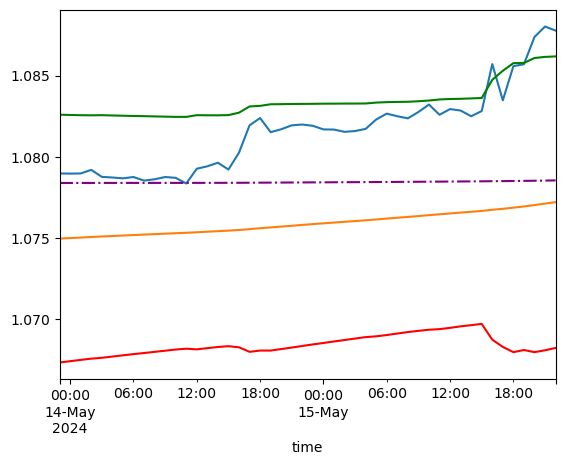

In [35]:
period = bars.index[-48:]

close.loc[period].plot()
ema.loc[period].plot()
upper.loc[period].plot(color='g')
lower.loc[period].plot(color='r')

ema_filter.loc[period].plot(color='purple',linestyle='-.')

In [43]:
long_entry = np.where(
            (close <= lower) & (close >= ema_filter), 1, 0
        )
short_entry = np.where(
    (close >= upper) & (close <= ema_filter), -1, 0
)

sides = pd.Series(long_entry + short_entry, index=close.index)

In [44]:
sides.tail(20)

time
2024-05-15 01:00:00    0
2024-05-15 02:00:00    0
2024-05-15 03:00:00    0
2024-05-15 04:00:00    0
2024-05-15 05:00:00    0
2024-05-15 06:00:00    0
2024-05-15 07:00:00    0
2024-05-15 08:00:00    0
2024-05-15 09:00:00    0
2024-05-15 10:00:00    0
2024-05-15 11:00:00    0
2024-05-15 12:00:00    0
2024-05-15 13:00:00    0
2024-05-15 14:00:00    0
2024-05-15 15:00:00    0
2024-05-15 16:00:00    0
2024-05-15 17:00:00    0
2024-05-15 18:00:00    0
2024-05-15 19:00:00    0
2024-05-15 20:00:00    0
dtype: int32

<Axes: >

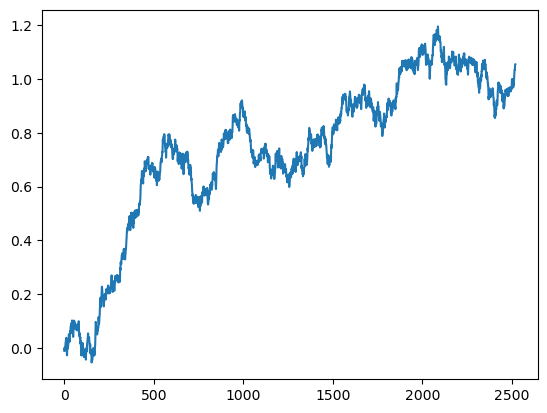

In [19]:
ax = plt.subplot()

a.cumsum().plot(ax=ax)

In [17]:
a = pd.Series(np.random.normal(0.08/256,0.2/16,252*10))

In [14]:
c

'd'

In [3]:
def read_json(filename):
    with open(filename) as f:
        j = json.load(f)
    return j


ac_info = read_json("config/mt5_account.json")["mt5-demo"]
db_info = read_json("config/postgres_info.json")["pre-trade"]
params = read_json("config/parameters.json")

In [4]:
import datetime as dt

In [5]:
params = {
    "technicals": {
        "ewmac": {"lookbacks": [6, 12, 24, 48, 96, 192, 384, 786, 1572]},
        "dcb": {"lookbacks": [6, 12, 24, 48, 96, 192, 384, 786, 1572]},
        "macd": {"lookbacks": [6, 12, 24, 48, 96, 192, 384, 786, 1572]},
        "bbz": {"lookbacks": [6, 12, 24, 48, 96, 192, 384, 786, 1572]},
        "rsi": {"lookbacks": [6, 12, 24, 48, 96, 192, 384, 786, 1572]},
        "skew": {"lookbacks": [6, 12, 24, 48, 96, 192, 384, 786, 1572]},
        "avghv": {"lookbacks": [6, 12, 24, 48, 96, 192, 384, 786, 1572]},
        "volz": {"lookbacks": [6, 12, 24, 48, 96, 192, 384, 786, 1572]},
    }
}

In [6]:
pdm = PretradeDataManager(ac_info, db_info, params)
df = pdm.get_universe()
pdm.close()
df

Logged in as 80273160
Connected to pre-trade


,id,symbol,asset_class,nominal_currency,description
0,2001,AUDUSD,currency,USD,Australian Dollar (in US Dollar)
1,2002,EURUSD,currency,USD,Euro (in US Dollar)
2,2003,GBPUSD,currency,USD,UK Pound (in US Dollar)
3,2004,NZDUSD,currency,USD,New Zealand Dollar (in US Dollar)
4,2005,USDCHF,currency,CHF,US Dollar (in Swiss Franc)
5,2006,USDCAD,currency,CAD,US dollar (in Canadian Dollar)
6,2007,USDJPY,currency,JPY,US dollar (in Japanese Yen)


In [7]:
from technical_models import EWMAC_Ridge, DCB_Ridge, TRT_Ridge, BBZ_Ridge, RSI_Ridge,BBZ_Linear

pdm = PretradeDataManager(ac_info, db_info, params)

symbols = pdm.get_universe()["symbol"][:]
mfs = pd.DataFrame()
fs = pd.DataFrame()
poss = pd.DataFrame()
poss_meta = pd.DataFrame()
rets = pd.DataFrame()

for symbol in symbols:
    print(symbol)
    bars = pdm.get_bars(symbol)

    train_size = 30000  # ~5 years
    step = 1500
    start = -30000 - step
    end = -1
    retrain_freq = step

    metaforecasts = list()
    forecasts = list()

    lookbacks = params["technicals"]["bbz"]["lookbacks"]
    lookforward = 6
    meta_params = params["technicals"]

    idx = bars.index[start]

    data = bars.iloc[:start].iloc[-train_size:]

    model = BBZ_Ridge(
        model_weight=1,
        open=data.open,
        high=data.high,
        low=data.low,
        close=data.close,
        volume=data.tick_volume,
        lookbacks=lookbacks,
        lookforward=lookforward,
        meta_params=meta_params,
    )
    
    while True:
        if start % retrain_freq == 0:
            model.train_model()
            #model.produce_forecasts()
            #model.train_metamodel()
            model.save_models()

        start += step

        if start > end:
            break

        data = bars.iloc[:start].iloc[-train_size:]

        model = BBZ_Ridge(
            model_weight=1,
            open=data.open,
            high=data.high,
            low=data.low,
            close=data.close,
            volume=data.tick_volume,
            lookbacks=lookbacks,
            lookforward=lookforward,
            meta_params=meta_params,
        )

        #metaforecasts.append(model.get_metaforecasts().iloc[-step:])
        #forecasts.append(model.forecasts.iloc[-step:])
        forecasts.append(model.get_forecasts().iloc[-step:])

    #metaforecasts = pd.concat(metaforecasts, axis=0)
    forecasts = pd.concat(forecasts, axis=0)
    #mfs[symbol] = metaforecasts
    fs[symbol] = forecasts
    pos = (
        (np.around(forecasts * 5) / 5)
        .clip(upper=1, lower=-1)
        .rolling(lookforward)
        .mean()
    )
    #pos_meta = (
    #   (np.around(metaforecasts * 5) / 5)
    #   .clip(upper=1, lower=-1)
    #   .rolling(lookforward)
    #   .mean()
    #)
    ret = np.log(bars.close).diff().shift(-1)
    poss[symbol] = pos
    #poss_meta[symbol] = pos_meta
    rets[symbol] = ret

pdm.close()

Logged in as 80273160
Connected to pre-trade
AUDUSD
EURUSD
GBPUSD
NZDUSD
USDCHF
USDCAD
USDJPY


KeyboardInterrupt: 

<Axes: xlabel='time'>

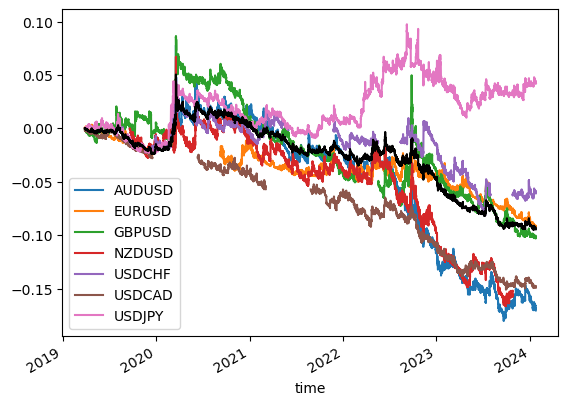

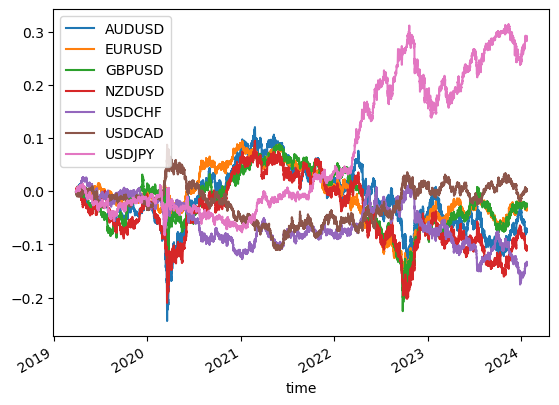

In [ ]:
commission = 0.00001
spread = 0.00004 / 2
slippage = 0.00001
c = poss.diff().abs() * (spread + commission + slippage)
#c_meta = poss_meta.diff().abs() * (spread + commission + slippage)

(poss * rets - c).loc[:].cumsum().plot()
(poss * rets - c).loc[:].mean(axis=1).cumsum().plot(color='black',linestyle='-')
#(poss_meta * rets - c_meta).loc[:].cumsum().plot()
#(poss_meta * rets - c_meta).loc[:].mean(axis=1).cumsum().plot(color='black',linestyle='-')
rets.loc[poss.index].loc[:].cumsum().plot()

In [9]:
(model.linear.coef_,model.)

array([0.        , 0.01475912, 0.00990447, 0.        , 0.        ,
       0.        , 0.        , 0.00425964, 0.01529383])

In [34]:
from models import get_cusum

ti = TechnicalIndicator(model.open, model.high, model.low, model.close, model.volume)
feature = ti.get_all(model.meta_params)

log_close = np.log(model.close)
log_ret = log_close.diff(model.lookforward).shift(-model.lookforward)
norm_ret = normalize(log_ret / ti.get_AVGHV(), method="zeromean")

feature["forecast"] = model.forecasts
feature["prevret"] = model.forecasts.shift(model.lookforward) * norm_ret.shift(
    model.lookforward
)

#pos = get_cusum(model.forecasts)
# pos = np.sign(self.forecasts)

label = np.sign(pos * norm_ret).dropna().clip(lower=0).rename("label")

train = pd.concat([label, feature], axis=1).dropna()
# print("number of meta samples:")
# print(len(train))

model.meta_logistic.score(y=train.label, X=train.drop(columns="label"))

0.49254607878568846

In [ ]:
poss.to_csv('others/trt_pos.csv')

In [ ]:
ewmac_pos = pd.read_csv('others/ewmac_pos.csv')
dcb_pos = pd.read_csv('others/dcb_pos.csv')
trt_pos = pd.read_csv('others/trt_pos.csv')
rsi_pos = pd.read_csv('others/rsi_pos.csv')
bbz_pos = pd.read_csv('others/bbz_pos.csv')

In [ ]:
corr = list()
for symbol in symbols:
    strats = pd.DataFrame(
        {
            "ewmac": ewmac_pos[symbol],
            "dcb": dcb_pos[symbol],
            "trt": trt_pos[symbol],
            "bbz": bbz_pos[symbol],
            "rsi": rsi_pos[symbol],
        }
    )
    corr.append(strats.corr())
    print(strats.corr())

          ewmac       dcb       bbz       rsi
ewmac  1.000000  0.352314  0.724875  0.454825
dcb    0.352314  1.000000  0.417317  0.457022
bbz    0.724875  0.417317  1.000000  0.649332
rsi    0.454825  0.457022  0.649332  1.000000
          ewmac       dcb       bbz       rsi
ewmac  1.000000  0.360115  0.620298  0.335869
dcb    0.360115  1.000000  0.616538  0.532947
bbz    0.620298  0.616538  1.000000  0.639287
rsi    0.335869  0.532947  0.639287  1.000000
          ewmac       dcb       bbz       rsi
ewmac  1.000000  0.451023  0.746157  0.437401
dcb    0.451023  1.000000  0.545842  0.408797
bbz    0.746157  0.545842  1.000000  0.616544
rsi    0.437401  0.408797  0.616544  1.000000
          ewmac       dcb       bbz       rsi
ewmac  1.000000  0.315943  0.652231  0.319744
dcb    0.315943  1.000000  0.385235  0.454103
bbz    0.652231  0.385235  1.000000  0.483854
rsi    0.319744  0.454103  0.483854  1.000000
          ewmac       dcb       bbz       rsi
ewmac  1.000000  0.340009  0.69239

<Axes: >

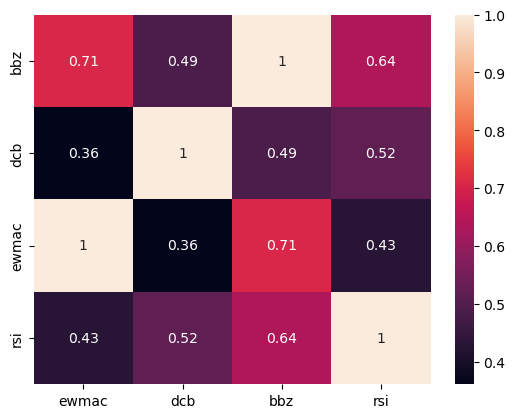

In [ ]:
corr_df = pd.concat(corr,axis=0).groupby(axis=0,level=0).mean()
sns.heatmap(corr_df,annot=True)

In [13]:
w = 1 / rets.ewm(24*20).std()
w = w.div(w.sum(axis=1),axis=0).shift(1)
w

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCHF,USDCAD,USDJPY
time,,,,,,,
2013-05-08 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-08 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-08 15:00:00,0.724523,0.037550,0.127067,0.038217,0.017854,0.033360,0.021430
2013-05-08 16:00:00,0.324585,0.112732,0.207584,0.105913,0.057518,0.113842,0.077826
2013-05-08 17:00:00,0.271761,0.131628,0.154024,0.129672,0.073694,0.149104,0.090118
...,...,...,...,...,...,...,...
2024-04-19 19:00:00,0.110021,0.162251,0.148499,0.110658,0.130147,0.174586,0.163839
2024-04-19 20:00:00,0.110056,0.162291,0.148248,0.110694,0.130188,0.174644,0.163879
2024-04-19 21:00:00,0.110044,0.162314,0.148270,0.110681,0.130245,0.174522,0.163924


In [14]:
#pnl_meta = (poss_meta * rets - c_meta).mul(w,axis=0).sum(axis=1).dropna().resample('d').sum()
#pnl_meta = pnl_meta * (.15/16/pnl_meta.std())
#e_meta = Evaluator(pnl_meta)


pnl = (poss * rets - c).mul(w,axis=0).sum(axis=1).dropna().resample('d').sum()
pnl = pnl * (.15/16/pnl.std())
e = Evaluator(pnl)

In [15]:
e.get_summary()

,Value,Sample size,P-value
Cum Return,0.0272,1.0000,NaN
Mean,0.0127,4000.0000,NaN
Vol,0.1488,4000.0000,NaN
SR,0.0485,4000.0000,0.0022
CAPM Alpha,0.0266,2742.0000,0.6219
Carhart Alpha,0.0262,2742.0000,0.6258
Beta,-0.1398,2742.0000,0.0000
Skew,0.5267,4000.0000,NaN
Skew (M),0.5680,132.0000,NaN
Kurt,36.4363,4000.0000,NaN


In [44]:
columns = pd.MultiIndex.from_product(
    [["Raw", "Meta"], ["Value", "Sample size", "P-value"]]
)


df = pd.concat([e.get_summary(), e_meta.get_summary()], axis=1)
df.columns = columns

df

Raw                        Meta                    
                    Value Sample size P-value   Value Sample size P-value
Cum Return        13.8839      1.0000     NaN 14.6048      1.0000     NaN
Mean               0.1811   4000.0000     NaN  0.1841   4000.0000     NaN
Vol                0.1488   4000.0000     NaN  0.1488   4000.0000     NaN
SR                 2.1183   4000.0000  0.0000  2.1183   4000.0000  0.0000
CAPM Alpha         0.6169    456.0000  0.0053  0.6169    456.0000  0.0053
Carhart Alpha      0.6150    456.0000  0.0053  0.6150    456.0000  0.0053
Beta              -0.1767    456.0000  0.0077 -0.1767    456.0000  0.0077
Skew               2.1931   4000.0000     NaN  2.4505   4000.0000     NaN
Skew (M)           5.3284    132.0000     NaN  4.9689    132.0000     NaN
Kurt              37.4243   4000.0000     NaN 41.3844   4000.0000     NaN
Avg Drawdown      -0.0513   1484.0000     NaN -0.0465   1636.0000     NaN
Max Drawdown      -0.1703      1.0000     NaN -0.2169      1.0000     NaN
Downside Risk      0.1213    695.0000     NaN  0.1227    667.0000     NaN
VaR 95%           -0.0106   4000.0000     NaN -0.0095   4000.0000     NaN
Exp Shortfall 95% -0.0203    200.0000     NaN -0.0196    200.0000     NaN
VaR 99%           -0.0261   4000.0000     NaN -0.0243   4000.0000     NaN
Exp Shortfall 99% -0.0378     40.0000     NaN -0.0387     40.0000     NaN

<Axes: xlabel='time'>

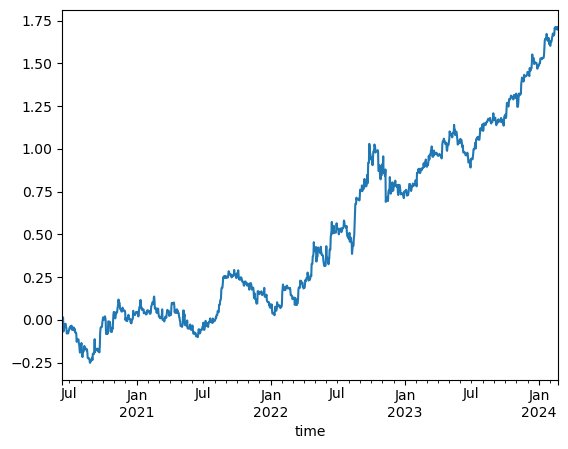

In [31]:
pnl.cumsum().plot()

In [ ]:
(poss * rets - c).mean(axis=1)

In [25]:
(poss * rets - c).dropna()

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCHF,USDCAD,USDJPY
time,,,,,,,


In [17]:
idx

Timestamp('2024-03-22 22:00:00')

In [14]:
ti = TechnicalIndicator(
    open=data.open,
    high=data.high,
    low=data.low,
    close=data.close,
    volume=data.tick_volume,
)
raw_signal = pd.DataFrame({n: ti.get_BBZ(n) for n in lookbacks}).dropna()

# Train Ridge
log_close = np.log(data.close)
log_ret = log_close.diff().shift(-1)

label = np.sign(log_ret).rename("label")

train = pd.concat([label, raw_signal], axis=1).dropna()

In [9]:
model.meta_logistic.score(y=train.label, X=train.drop(columns="label"))

LogisticRegressionCV(cv=10, fit_intercept=False, penalty='l1', solver='saga')

<Axes: xlabel='time'>

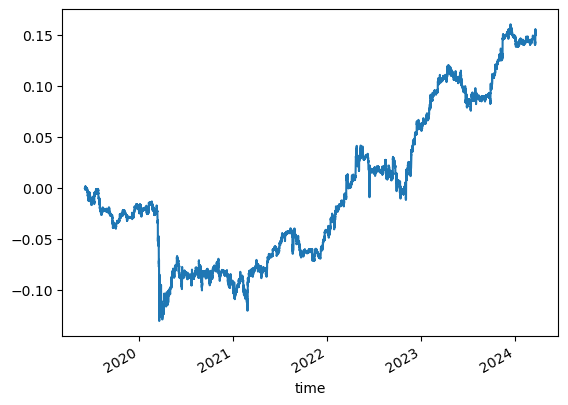

In [21]:
(model.forecast.rolling(6).mean()*log_close.diff().shift(-1)).cumsum().plot()

<Axes: >

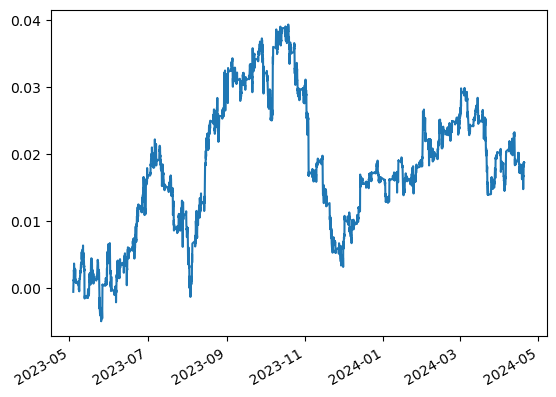

In [10]:
(poss * rets - c).mean(axis=1).cumsum().plot()

<Axes: xlabel='time'>

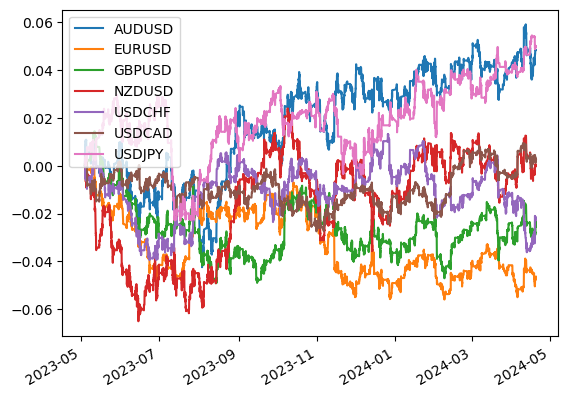

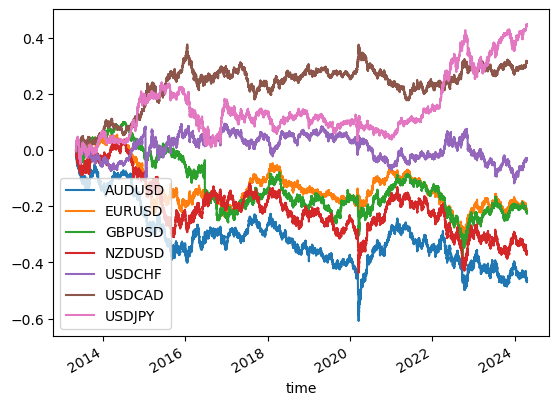

In [14]:
commission = 0.00001
spread = 0.00004 / 2
slippage = 0.00001
c = np.sign(poss).diff().abs() * (spread + commission + slippage)

(np.sign(poss) * rets - c).cumsum().plot()
rets.cumsum().plot()

<Axes: >

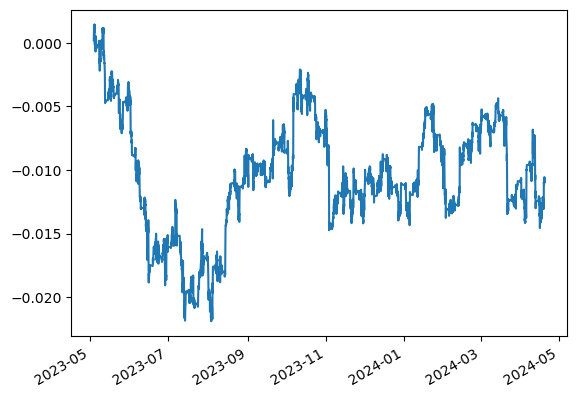

In [10]:
(poss * rets - c).mean(axis=1).cumsum().plot()

In [13]:
(poss * rets ).corr()

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCHF,USDCAD,USDJPY
AUDUSD,1.000000,0.318630,0.336945,0.683376,0.198871,0.407715,0.010584
EURUSD,0.318630,1.000000,0.494349,0.265172,0.346007,0.112033,-0.031644
GBPUSD,0.336945,0.494349,1.000000,0.267207,0.256706,0.152770,0.005238
NZDUSD,0.683376,0.265172,0.267207,1.000000,0.151561,0.346209,0.035464
USDCHF,0.198871,0.346007,0.256706,0.151561,1.000000,0.123307,-0.166700
USDCAD,0.407715,0.112033,0.152770,0.346209,0.123307,1.000000,-0.046498
USDJPY,0.010584,-0.031644,0.005238,0.035464,-0.166700,-0.046498,1.000000


<Axes: >

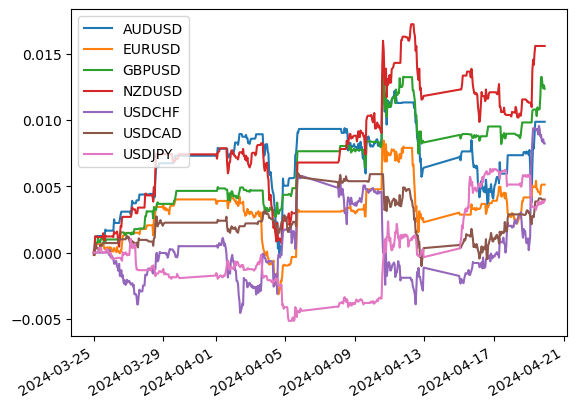

In [13]:
pnls.cumsum().plot()

<Axes: >

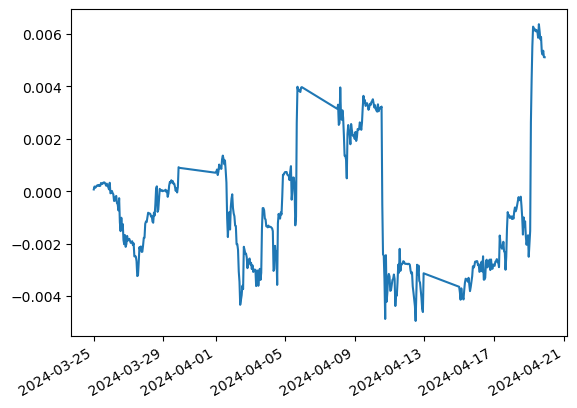

In [9]:
log_ret = np.log(bars.close).diff().shift(-1)
(forecasts * log_ret).cumsum().plot()

In [9]:
forecasts

2024-03-25   -0.470835
dtype: float64

Logged in as 80273160
Connected to pre-trade


C:\Users\benka\AppData\Local\Temp\ipykernel_65128\2318184931.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pf = pd.Series(index=lookbacks, name=symbol)
C:\Users\benka\AppData\Local\Temp\ipykernel_65128\2318184931.py:33: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sr = pd.Series(index=lookbacks, name=symbol)
C:\Users\benka\AppData\Local\Temp\ipykernel_65128\2318184931.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cost = pd.Series(index=lookbacks, name=symbol)


[0.67911612 0.2328276  0.06410745]
[-0.02141     0.00958415  0.09843901]
0.962288958469781
1.2060658001360716
0.597089016910472


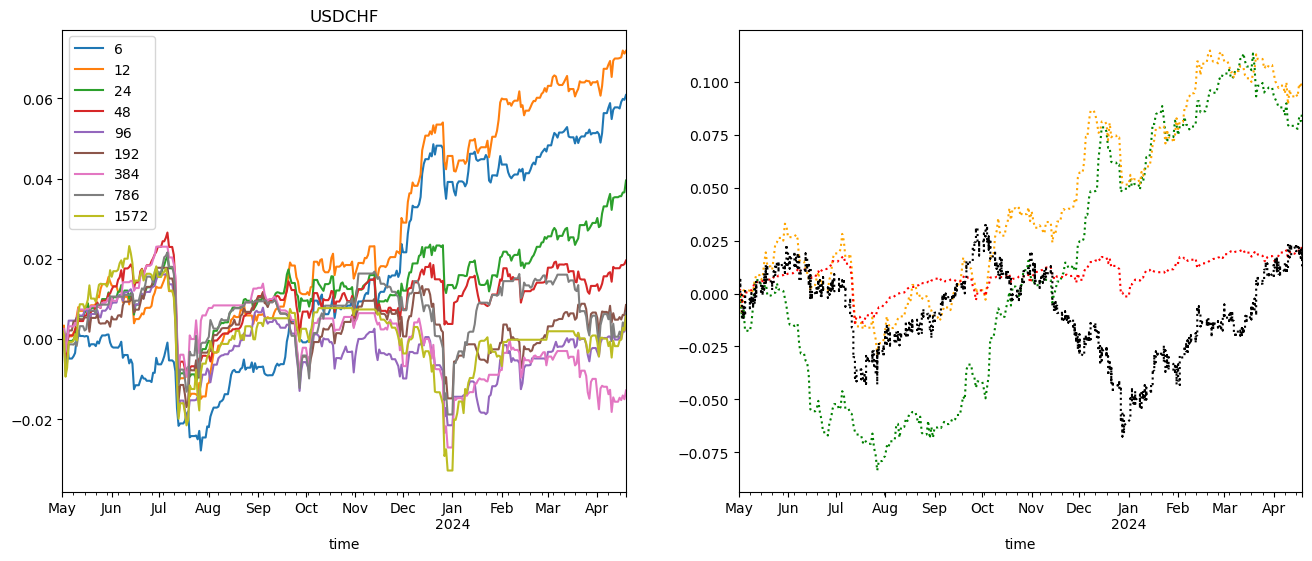

In [24]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, RidgeCV

l = list()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

pdm = PretradeDataManager(ac_info, db_info, params)


pdm.set_universe()
symbols = pdm.get_universe()["symbol"]
symbols = ["USDCHF"]

# corr_l = list()
pfs = pd.DataFrame()
srs = pd.DataFrame()
costs = pd.DataFrame()

for symbol in symbols:

    df = pd.DataFrame()

    bars = pdm.get_bars(symbol)

    log_close = np.log(bars.close)
    log_ret = log_close.diff().shift(-1)

    lookbacks = params["technicals"]["rsi"]["lookbacks"]

    pf = pd.Series(index=lookbacks, name=symbol)
    sr = pd.Series(index=lookbacks, name=symbol)
    cost = pd.Series(index=lookbacks, name=symbol)

    ti = TechnicalIndicator(
        bars.open, bars.high, bars.low, bars.close, bars.tick_volume
    )

    signal_df = pd.DataFrame()
    for lookback in lookbacks:

        # Ind ============================
        signal = ti.get_BBZ(lookback)

        # filter = ti.get_EWMAC(lookback)

        signal_df[lookback] = signal

        pos = -np.around(signal.clip(lower=-1, upper=1) * 2) / 2
        # pos = pd.Series(np.where(np.sign(pos) == np.sign(filter), pos, 0), pos.index)

        # pnl = (pos * (log_ret - abs(0))).resample("d").sum()

        pnl = (pos * log_ret).resample("d").sum()

        commission = 0.00001
        spread = 0.00004 / 2
        slippage = 0.00001
        c = (pos.diff().abs() * (spread + commission + slippage)).resample("d").sum()

        df[lookback] = pnl - c

        # pf[lookback] = pnl.clip(lower=0).sum() / -pnl.clip(upper=0).sum()
        sr[lookback] = pnl.mean() / pnl.std() * np.sqrt(252)
        cost[lookback] = c.mean() / pnl.std() * np.sqrt(252)

    # OLS ============================

    signal = signal_df
    label = log_ret / log_ret.abs().mean()

    idx = signal.dropna().index.intersection(log_ret.dropna().index)
    x = signal.loc[idx, :]
    y = label.loc[idx]

    model = RidgeCV(fit_intercept=False,cv=10)
    # model = LinearRegression()
    model.fit(X=x.loc[:"2022"], y=y.loc[:"2022"])
    # print(model.score(X=x.loc["2020":], y=y.loc["2020":]))
    # print(model.coef_)

    # pos = signal.loc["2020":, 0] * np.sign(model.coef_[0])
    pos = normalize(pd.Series(model.predict(X=x.loc[:]), index=x.loc[:].index))
    pos = np.sign(pos.clip(lower=-1, upper=1))

    pnl = (pos * log_ret).resample("d").sum().dropna()

    commission = 0.00001
    spread = 0.00004 / 2
    slippage = 0.00001
    c = (pos.diff().abs() * (spread + commission + slippage)).resample("d").sum()
    ols = pnl - c

    # PCA OLS   ============================

    pca = PCA(n_components=3)
    pca.fit(signal_df.loc[:"2022"].dropna())

    signal = pd.DataFrame(
        pca.transform(signal_df.dropna()), index=signal_df.dropna().index
    )
    print(pca.explained_variance_ratio_)
    #signal = normalize(signal, method="zeromean")

    idx = signal.dropna().index.intersection(log_ret.dropna().index)
    x = signal.loc[idx, :]
    y = label.loc[idx]

    model = RidgeCV(fit_intercept=False,cv=10)
    # model = LinearRegression()
    model.fit(X=x.loc[:"2022"], y=y.loc[:"2022"])
    # print(model.score(X=x.loc["2020":], y=y.loc["2020":]))
    print(model.coef_)

    # pos = signal.loc["2020":, 0] * np.sign(model.coef_[0])
    pos = normalize(pd.Series(model.predict(X=x.loc[:]), index=x.loc[:].index))
    pos = np.sign(pos.clip(lower=-1, upper=1))

    pnl = (pos * log_ret).resample("d").sum().dropna()

    c = (pos.diff().abs() * (spread + commission + slippage)).resample("d").sum()
    pca_ols = pnl - c

    # ====================

    df.loc["2023-05":, :].cumsum().plot(title=symbol, ax=ax1)
    ols.loc["2023-05":].cumsum().plot(color="green", linestyle=":", ax=ax2)
    pca_ols.loc["2023-05":].cumsum().plot(color="orange", linestyle=":", ax=ax2)
    df.loc["2023-05":, :].mean(axis=1).cumsum().plot(color="red", linestyle=":", ax=ax2)
    log_ret.loc["2023-05":].cumsum().plot(color="black", linestyle=":", ax=ax2)
    # corr_l.append(signal_df.corr())

    print(ols.loc["2023-05":].mean() / ols.loc["2023-05":].std() * np.sqrt(252))
    print(pca_ols.loc["2023-05":].mean() / pca_ols.loc["2023-05":].std() * np.sqrt(252))
    print(
        df.loc["2023-05":, :].mean(axis=1).mean()
        / df.loc["2023-05":, :].mean(axis=1).std()
        * np.sqrt(252)
    )

    pfs[symbol] = pf
    srs[symbol] = sr
    costs[symbol] = cost
# corr_df = pd.concat(corr_l).groupby(axis=0,level=0).mean()
pdm.close()

In [ ]:
symbols = ["AUDUSD", "EURUSD", "GBPUSD", "NZDUSD", "USDCHF", "USDCAD", "USDJPY"]
strat = "rsi"


lookback = 96

l = list()


pdm = PretradeDataManager(ac_info, db_info, params)


pdm.set_universe()


for symbol in symbols:

    bars = pdm.get_bars(symbol)

    technicals = TechnicalIndicator(
        bars.open, bars.high, bars.low, bars.close, bars.tick_volume
    ).get_all(params["technicals"])
    log_close = np.log(bars.close)

    log_return = log_close.diff(lookback).shift(-lookback)

    #pnl = log_close.diff().shift(-1) * -np.sign(technicals[f"{strat}_{lookback}"])
    #log_return = pnl.rolling(lookback).mean().shift(-lookback)
    
    #trt = TechnicalIndicator(
    #    bars.open, bars.high, bars.low, bars.close, bars.tick_volume
    #).get_TRT(lookback).shift(-lookback)
    events = cusum_index(log_return, n_std=0.5)

    ret = log_close.diff().shift(-1).rename("ret")

    label = pd.Series((np.sign(log_return/log_return.abs().mean())), index=log_return.index).rename(
        "label"
    )

    features = technicals[f"{strat}_{lookback}"]

    df = pd.concat([ret, label, features], axis=1).loc[events].dropna()

    df["symbol"] = symbol
    l.append(df)
pdm.close()

In [ ]:
df = pd.concat(l,axis=0).sort_index()
#sub_df = df.sample(frac=0.5,replace=False)
train = df.iloc[:len(df)//2]
test = df.iloc[len(df)//2:]

In [ ]:
train.label.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

model = LogisticRegression()
# model = GaussianNB()
# model = RandomForestClassifier(n_estimators=500, max_depth=3)

y, x = train.label, train.drop(columns=["symbol", "ret", "label"])

model.fit(X=x, y=y)
print(model.score(X=x, y=y))
print(model.score(X=test.drop(columns=["symbol", "ret", "label"]), y=test.label))

In [ ]:
from sklearn.metrics import confusion_matrix

def get_conf_mat(y_pred, y_true, k_list=None, pred_rate=False):
    if k_list is None:
        k_list = np.sort(y_true.unique())
    cm = pd.DataFrame(
        confusion_matrix(y_pred=y_pred, y_true=y_true),
        index=pd.Index(k_list, name="True"),
        columns=pd.Index(k_list, name="Pred"),
    )
    if pred_rate:
        cm = np.around(cm.div(cm.sum(axis=0), axis=1), 2)
    return cm

In [ ]:
get_conf_mat(model.predict(test.drop(columns=["symbol", "ret", "label"])),test.label,pred_rate=True)

In [ ]:
from scipy.stats import norm


def get_pnl(g):
    prob = pd.DataFrame(
        model.predict_proba(g.drop(columns=["symbol", "ret", "label"])),
        index=g.index,
    )
    pred = pd.Series(
        model.predict(g.drop(columns=["symbol", "ret", "label"])),
        index=g.index,
        name="pred",
    )
    p = prob.max(axis=1)
    z = (p - 1 / 2) / np.sqrt(p * (1 - p))
    z = pd.Series(norm.cdf(z), index=z.index)

    size = pred * (2 * z - 1)
    # size.plot(kind="hist", alpha=0.2)

    pos = (size * -np.sign(g[f"{strat}_{lookback}"])).rolling(lookback).mean()
    pos.plot()

    pnl = pos * g.ret - pos.diff().abs() * 0.00004

    return pnl


def get_pnl_model(g):
    prob = pd.DataFrame(
        model.predict_proba(g.drop(columns=["symbol", "ret", "label"])),
        index=g.index,
    )
    pred = pd.Series(
        model.predict(g.drop(columns=["symbol", "ret", "label"])),
        index=g.index,
        name="pred",
    )
    p = prob.max(axis=1)
    z = (p - 1 / 2) / np.sqrt(p * (1 - p))
    z = pd.Series(norm.cdf(z), index=z.index)

    bet = (pred - 1) * (2 * z - 1)

    pos = (bet).rolling(lookback).mean()

    pnl = pos * g.ret - pos.diff().abs() * 0.00004

    return pnl

In [ ]:
def get_rawpnl(g):
    pos = -g[f"{strat}_{lookback}"].clip(lower=-2,upper=2)/2
    pnl = pos * g.ret - pos.diff().abs() * 0.00004
    return pnl

In [ ]:
pnl = test.groupby('symbol').apply(get_pnl).unstack().T
pnl_model = test.groupby('symbol').apply(get_pnl_model).unstack().T
rawpnl = test.groupby('symbol').apply(get_rawpnl).unstack().T

In [ ]:
pnl.cumsum().plot()
pnl.mean(axis=1).cumsum().plot(color='black',linestyle='-.')
pnl_model.cumsum().plot()
pnl_model.mean(axis=1).cumsum().plot(color='black',linestyle='-.')
rawpnl.cumsum().plot()
rawpnl.mean(axis=1).cumsum().plot(color='black',linestyle='-.')

In [ ]:
pnl.mean()/pnl.std()*np.sqrt(24*250)

In [ ]:
pnl_model.mean()/pnl_model.std()*np.sqrt(24*250)

In [ ]:
rawpnl.mean()/rawpnl.std()*np.sqrt(24*250)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model,
    train.drop(columns=["symbol", "ret", "label"]),
    train.label,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

forest_importances = pd.Series(
    result.importances_mean,
    index=train.drop(columns=["symbol", "ret", "label"]).columns,
)
err = pd.Series(
    result.importances_std, index=train.drop(columns=["symbol", "ret", "label"]).columns
)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=err, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
forest_importances = (
    pd.Series(
        result.importances_mean,
        index=test.drop(columns=["symbol", "ret", "label"]).columns,
    )
    .sort_values(ascending=False)
    .head(20)
)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=err[forest_importances.index], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
forest_importances.index.sort_values()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import ElasticNet

idx = list()
pred = list()
for i in log_ret.index[96:]:
  idx.append(i)
  #model = ARIMA(log_ret.loc[:i].iloc[-96:],order=(1,0,1)).fit()
  #pred.append(model.forecast().values[0])
  model = ElasticNet(alpha=0.5,l1_ratio=0.5)
  y = log_ret.loc[:i].iloc[-96:]
  x = y.shift(1).to_numpy().reshape(-1,1)[1:]
  model.fit(X=x,y=(y)[1:])
  pred.append(model.predict([[y[-1]]]))
  
forecast = pd.Series(pred,idx)

In [ ]:
pos_EN = -np.sign(forecast)

In [ ]:
log_ret.shift(-1).loc[forecast.index].cumsum().plot()
(pos_ARIMA * log_ret.shift(-1) - pos_ARIMA.diff().abs() * 0.00004).dropna().cumsum().plot()
(pos_LogReg * log_ret.shift(-1) - pos_LogReg.diff().abs() * 0.00004).dropna().cumsum().plot()
(pos_EN * log_ret.shift(-1) - pos_EN.diff().abs() * 0.00004).dropna().cumsum().plot()
(pos_Rule * log_ret.shift(-1) - pos_Rule.diff().abs() * 0.00004).dropna().cumsum().plot()

In [ ]:
log_ret.shift(-1).cumsum().plot()
(pos_Base * log_ret.shift(-1) - pos_Base.diff().abs() * 0.00004).dropna().cumsum().plot()
(pos_Rule * log_ret.shift(-1) - pos_Rule.diff().abs() * 0.00004).dropna().cumsum().plot()
(pos_EN * log_ret.shift(-1) - pos_EN.diff().abs() * 0.00004).dropna().cumsum().plot()

In [ ]:
trend = log_close.ewm(24).mean() - log_close.ewm(96).mean()
pos = trend / (log_close*(log_close.diff().ewm(96).std()))
pos = pos.clip(upper=2,lower=-2)/2
pos_Base = pos

In [ ]:
trend = log_close.ewm(96).mean()
dev = ((log_close - trend)**2).rolling(96).mean()**0.5
upper = trend + 2*dev
lower = trend - 2*dev
pos = np.sign(trend.diff(96))
long = np.where((pos==1)&(trend>=lower),1,0)
short = np.where((pos==-1)&(trend<=upper),-1,0)
pos_Rule = pd.Series(long+short,index=trend.index)

dev_nt = (log_close.diff()**2).rolling(96).mean()**0.5
dev_div = (dev-dev_nt)
dev_div = (dev_div - dev_div.rolling(96).mean())/dev_div.rolling(96).std()

pos = np.where(dev_div <= -1, pos_Rule,0)
pos_Rule = pd.Series(pos,index=pos_Rule.index)

In [ ]:
pnl = pos_Rule * log_ret.shift(-1)

In [ ]:
df = pd.concat([pnl*6000,pd.cut(dev_div,bins=4)],axis=1)

In [ ]:
df.groupby('close').mean()

In [ ]:
model.forecast().values[0]

In [ ]:
log_close.plot()
model.predict.plot()

In [ ]:
model.predict()

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

dataset = log_ret.diff().dropna()

fig,axes = plt.subplots(4,3,figsize=(20,15))

for i,data in enumerate(np.array_split(dataset,10)):
  ax = axes[i//3,i%3]
  plot_acf(data,ax=ax)

In [ ]:
ti = TechnicalIndicator(bars.open, bars.high, bars.low, bars.close, bars.tick_volume)
#bdf = ti.get_all(params["technicals"])

In [ ]:
ent = bdf.apply(get_entropy)
ent[ent < 0.5]

In [ ]:
from sklearn.linear_model import LinearRegression


def test(lookahead):
    log_ret = np.log(bars.close).diff(lookahead).shift(-lookahead)
    vol = ti.get_EWHV(lookahead)
    signal = (
        ti.get_EWMAC(lookahead)
    )
    dataset = pd.concat(
        [log_ret, vol, signal, signal.diff(lookahead), signal * vol],
        axis=1,
    ).dropna()
    dataset.columns = ["ret", "vol", "signal", "signal2", "signalvol"]

    train = dataset.iloc[: len(dataset) // 2]
    test = dataset.iloc[len(dataset) // 2 + lookahead :]

    predictors = dataset.columns.to_list()[1:]
    # print(predictors)

    train_y, train_x = train["ret"], train[predictors]
    test_y, test_x = test["ret"], test[predictors]

    model = LinearRegression()
    model.fit(y=train_y, X=train_x)

    pred = pd.Series(model.predict(test_x), index=test_x.index)
    pos = pd.Series(np.where(pred > pred.expanding().median(), 1, -1), index=pred.index)

    long_count = len(pos[pos > 0])
    count = len(pos)

    pnl = pos.rolling(lookahead).mean() * (np.log(bars.close).diff().shift(-1))
    pnl.dropna(inplace=True)
    pf = pnl.loc[pnl >= 0].sum() / -pnl.loc[pnl < 0].sum()
    sr = pnl.mean() / pnl.std() * np.sqrt(252 * 24)
    # pred.plot()

    pnl.cumsum().plot()
    # np.log(bars.close).diff().shift(-1).loc[pnl.index].cumsum().plot()

    return pf, sr, long_count, count, pnl, model.get_params()

In [ ]:
pfs = pd.Series()
srs = pd.Series()
pnls = pd.DataFrame()

lookaheads = [1, 6, 12, 24, 48, 96, 192, 384, 768, 1536]

for lookahead in lookaheads:
    pf, sr, long_count, count, pnl, params = test(lookahead)
    print(f"{lookahead}: {long_count/count} ({count})")
    pfs.loc[lookahead] = float(pf)
    srs.loc[lookahead] = float(sr)
    pnls[lookahead] = pnl
np.log(bars.close).plot(secondary_y=True)

In [ ]:
pnls.mean(axis=1).cumsum().plot()

In [ ]:
srs

In [ ]:
from sklearn.linear_model import ElasticNet


def test(lookahead, regime):
    log_ret = np.log(bars.close).diff(lookahead).shift(-lookahead)
    vol = ti.get_EWHV(96)
    if regime == -1:
        pass
    else:
        regime_idx = (vol >= vol.quantile(0.2 * (regime))) & (
            vol < vol.quantile(0.2 * (regime + 1))
        )
        vol = vol.loc[regime_idx]
    signal = (
        ti.get_EWMAC(lookahead)
        - ti.get_EWMAC(lookahead).rolling(lookahead * 2).median()
    )
    dataset = pd.concat(
        [log_ret, vol, signal],
        axis=1,
    ).dropna()
    dataset.columns = ["ret", "vol", "signal"]

    train = dataset.iloc[: len(dataset) // 2]
    test = dataset.iloc[len(dataset) // 2 + lookahead :]

    predictors = dataset.columns.to_list()[2:]
    # print(predictors)

    train_y, train_x = train["ret"], train[predictors]
    test_y, test_x = test["ret"], test[predictors]

    model = ElasticNet(alpha=0.2, l1_ratio=0.5)
    model.fit(y=train_y, X=train_x)

    pred = pd.Series(model.predict(test_x), index=test_x.index)
    pos = pd.Series(np.where(pred > pred.expanding().median(), 1, -1), index=pred.index)

    long_count = len(pos[pos > 0])
    count = len(pos)

    pnl = pos * (test_y - log_ret.mean()) / lookahead
    pf = pnl.loc[pnl >= 0].sum() / -pnl.loc[pnl < 0].sum()
    pf = pf
    # pred.plot()

    return pf, long_count, count, model.get_params()

In [ ]:
from itertools import product

df = pd.DataFrame()

lookaheads = [1, 6, 12, 24, 48, 96, 192, 384, 768, 1536]
regimes = [0, 1, 2, 3, 4]

for lookahead, regime in product(lookaheads, regimes):
    pf, long_count, count, params = test(lookahead, regime)
    print(f"{lookahead},{regime} : {long_count/count} ({count})")
    df.loc[lookahead, regime] = float(pf)
np.log(bars.close).plot(secondary_y=True)

In [ ]:
df[df > 1]

In [ ]:
def get_label(prc, vol, tp, sl, hd):
    log_prc = np.log(prc)
    log_ret = log_prc.diff().shift(-1)

    # tp = window**0.5
    # sl = window**0.5
    # hd = window

    # print(tp , sl , hd)
    label = []

    for i, ret in log_ret.items():
        up_bar = vol.loc[i] * tp
        low_bar = vol.loc[i] * -sl
        time_bar = hd

        future_ret = log_ret.loc[i:]
        cum_ret = ret
        cum_day = 1
        while True:
            # if cum_ret >= up_bar:
            #    label.append(1)
            #    break
            # elif cum_ret <= low_bar:
            #    label.append(0)
            #    break
            # elif cum_day >= time_bar or cum_day >= future_ret.shape[0]:
            #    label.append(0)
            #    break

            if (
                (cum_ret >= up_bar)
                or (cum_ret <= low_bar)
                or (cum_day >= time_bar or cum_day >= future_ret.shape[0])
            ):
                if cum_ret > 0:
                    label.append(1)
                else:
                    label.append(0)
                break

            ret = future_ret.iloc[cum_day]
            cum_day += 1
            cum_ret += ret

    label = pd.Series(label, index=log_ret.index, name="LABEL")
    return label

In [ ]:
def cusum_filter(data: pd.Series, n_std: float = 1) -> pd.Series:
    events = []
    s_pos, s_neg = 0, 0
    thr = data.std() * n_std
    diff = data.diff()
    for i in diff.index[1:]:
        s_pos = max(0, s_pos + diff.loc[i])
        s_neg = min(0, s_neg + diff.loc[i])
        if s_neg < -thr:
            s_neg = 0
            events.append(i)
        elif s_pos > thr:
            s_pos = 0
            events.append(i)
    return data.loc[events]

In [ ]:
pos = pd.Series(
    np.where(bdf["bbz_12"] > 2, -1, 0) + np.where(bdf["bbz_12"] < -2, 1, 0), bdf.index
)
pnl = pos * np.log(bars.close).diff().shift(-1)

In [ ]:
pnl.cumsum().plot()

In [ ]:
tp, sl, hd = 4, 4, 24
label = get_label(np.exp(pnl.cumsum()), technicals.avghv_96, tp, sl, hd)

In [ ]:
label.value_counts()

In [ ]:
filt = bdf.iloc[1000:60000].apply(cusum_filter).ffill()

In [ ]:
l = list()
names = ["skp", "rshv", "macd", "ewhv"]
for name in names:
    for lookback in params["technicals"][name]["lookbacks"]:
        l.append(f"{name}_{lookback}")
print(l)

In [ ]:
feat_names = l
feat = bdf.loc[:, feat_names]

In [ ]:
feat = bdf

In [ ]:
def sr(pnl):
    pnl = pnl.fillna(0)
    mu = pnl.mean()
    sig = pnl.std()
    n_per_year = 24 * 252
    sr = mu / sig * n_per_year**0.5
    return sr

In [ ]:
ns = np.random.choice(range(3000, 60000), size=10000, replace=False)
irs = list()

In [ ]:
ns = [10000]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

for n in ns:
    log_ret = np.log(bars.close).diff(12).shift(-12)
    vol = bdf.avghv_96
    label = pd.Series(np.where(log_ret > vol, 1, 0), index=log_ret.index)
    # label = np.sign(log_ret)
    dataset = pd.concat([label, feat.iloc[:-n].iloc[-6000:]], axis=1).dropna()

    train_set = dataset.iloc[:-24]
    train_y, train_x = train_set.iloc[:, 0], train_set.iloc[:, 1:]

    # model = LogisticRegression(penalty="l2", random_state=300300, max_iter=1000)
    # model = GaussianNB()
    model = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=300300)
    model.fit(y=train_y, X=train_x)

    pred = pd.Series(
        model.predict_proba(X=feat.iloc[-n:].iloc[384 : 384 + 6000])[:, 1],
        index=feat.iloc[-n:].iloc[384 : 384 + 6000].index,
    )
    # pred = pd.Series(model.predict(X=train_x),index=train_x.index).rolling(24).mean()

    # log_ret = np.log(bars.close).diff().shift(-1)
    # pnl = (pred * log_ret).dropna()
    # log_ret = log_ret.loc[pnl.index]
    # pnl.cumsum().plot()
    # log_ret.loc[pnl.index].cumsum().plot()
    # irs.append(sr(pnl-log_ret))

In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=train_x.columns).sort_index(
    ascending=False
)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
con_pos = (pos * pred).rolling(12).mean()
pnl = con_pos * np.log(bars.close).diff().shift(-1)
pnl.loc[pred.index].cumsum().plot()
(pos * np.log(bars.close).diff().shift(-1)).loc[pred.index].cumsum().plot()

In [ ]:
model.score(y=train_y, X=train_x)

In [ ]:
pnl.corr(log_ret)

In [ ]:
feat.plot()
plt.scatter(y=crit, x=crit.index, color="red")

In [ ]:
corr_df = filt.corr()
# reordered_cols = corr_df.mean().sort_values(ascending=False).index
# corr_df = corr_df.loc[reordered_cols,reordered_cols]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr_df[(corr_df >= 0.9) & (corr_df < 1)]
    .dropna(how="all", axis=1)
    .dropna(how="all"),
    annot=True,
    ax=ax,
)

In [ ]:
def get_label(prc, vol, tp, sl, hd):
    log_prc = np.log(prc)
    log_ret = log_prc.diff().shift(-1)

    label = []

    for i, ret in log_ret.items():
        up_bar = vol.loc[i] * tp
        low_bar = vol.loc[i] * -sl
        time_bar = hd

        future_ret = log_ret.loc[i:]
        cum_ret = ret
        cum_day = 1
        while True:
            if cum_ret >= up_bar:
                label.append(+2)
                break
            elif cum_ret <= low_bar:
                label.append(np.sign(cum_ret))
                break
            elif cum_day >= time_bar or cum_day >= future_ret.shape[0]:
                label.append(-2)
                break

            ret = future_ret.iloc[cum_day]
            cum_day += 1
            cum_ret += ret

    label = pd.Series(label, index=log_ret.index, name="LABEL")
    return label

In [ ]:
cols = (df.columns).to_list()
reordered_cols = cols[:-3] + cols[-3:][::-1]

In [ ]:
len(reordered_cols)

In [ ]:
ti = TechnicalIndicator(
    open=df.open, high=df.high, low=df.low, close=df.close, volume=df.tick_volume
)
df = ti.get_all(params["technicals"]["lookbacks"])

In [ ]:
df["time"] = df.index
df.columns[:-2]

In [ ]:
x = ((df.tick_volume) - (df.tick_volume).ewm(1500).mean()) / (
    ((df.tick_volume) - (df.tick_volume).ewm(1500).mean()) ** 2
).rolling(1500).mean() ** 0.5
x = ((df.tick_volume) - (df.tick_volume).ewm(1500).mean()) / (df.tick_volume).rolling(
    1500
).std()
x1 = (
    (np.log(df.tick_volume) - np.log(df.tick_volume).ewm(1500).mean())
    .expanding()
    .rank(pct=True)
)
x2 = TechnicalIndicator(volume=df.tick_volume).get_VOLZ(1500)
x.corr(y)

In [ ]:
x1.corr(x2)

In [ ]:
(np.log(df.tick_volume) - np.log(df.tick_volume).ewm(500).mean()).plot()

In [ ]:
x.plot()

In [ ]:
from statsmodels.api import OLS, add_constant

temp = pd.DataFrame({"x": x2, "y": y}).dropna()

model = OLS(endog=temp.y, exog=add_constant(temp.x))
result = model.fit()
p = result.params
result.summary()

In [ ]:
x_hat = np.arange(x2.min(), x2.max(), 0.01)
y_hat = p[0] + p[1] * x_hat

g = sns.FacetGrid(temp, height=6)
g = g.map(plt.scatter, "x", "y", edgecolor="w")

plt.plot(x_hat, y_hat, color="r")

In [ ]:
import mplfinance as mpf

mpf.plot(df.iloc[-500:], type="candle")

In [ ]:
ti = TechnicalIndicator(df.open, df.high, df.low, df.close, df.real_volume)
t = pd.DataFrame()
t["cchv"] = ti.get_CCHV(24)
t["atr"] = ti.get_ATR(24)
t["ewhv"] = ti.get_EWHV(24)
t["phv"] = ti.get_PHV(24)
t["gkhv"] = ti.get_GKHV(24)
t["rshv"] = ti.get_RSHV(24)
t["avghv"] = ti.get_AVGHV(24)
t.plot()

In [ ]:
sns.heatmap(t.corr(), annot=True)

In [ ]:
def get_symbol(symbol):
    db = DataBase()
    db.connect_by_dict(db_info)

    cmd = f"""
  SELECT * FROM bars 
  WHERE symbol = '{symbol}'
  ORDER BY id DESC
  LIMIT 100000;
  """

    df = pd.DataFrame(db.execute(cmd), columns=db.read_columns("bars"))
    df.set_index("time", inplace=True)
    df.sort_index(inplace=True)
    db.close()

    return df.close

In [ ]:
df = pd.DataFrame(
    {
        "AUDUSD": get_symbol("AUDUSD"),
        "EURUSD": get_symbol("EURUSD"),
        "GBPUSD": get_symbol("GBPUSD"),
    }
)

In [ ]:
signal = np.log(df).diff().sub(np.log(df).diff().mean(axis=1), axis=0)
pos = -np.around(signal.expanding().rank(pct=True) * 2 - 1) / 1
pnl = pos * np.log(df).diff().shift(-1) - pos.diff().abs() * 0.00001
pnl.cumsum().plot()

In [ ]:
((signal.expanding().mean() - signal) / signal.expanding().std()).AUDUSD.plot()